In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = "/content/drive/MyDrive/LatihanML/tripadvisor_hotel_reviews.csv"
df = pd.read_csv(path)
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [ ]:
# cek nilai kosong
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
# cek jika ada string kosong pada review, jika ada maka dihapus 
empty = []
# itertuples = iterasi tuples bernama dari dataframe
for i,review,rating in df.itertuples():
  if type(review) == str:
    if review.isspace():
      empty.append(i) #untuk mengambil index string kosong dari review
            
print(f"Total {len(empty)} string kosong dari review.")

Total 0 string kosong dari review.


In [ ]:
# cek jumlah nilai pada colum rating
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
# cek type data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Text(0, 0.5, 'Rating')

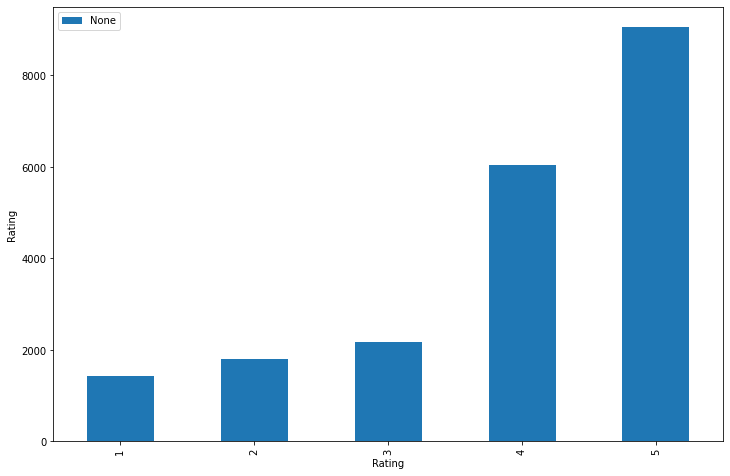

In [ ]:
# visualisasi data kolom Rating
plt.figure(figsize=(12,8))
df.groupby('Rating').size().plot(kind='bar',y='Rating',legend=True)
plt.ylabel('Rating')

In [ ]:
# Modifikasi rating

df["Rating"] = df["Rating"].replace([1, 2], "Negatif")
df["Rating"] = df["Rating"].replace([4, 5], "Positif")
df["Rating"] = df["Rating"].replace([3], "Netral")
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Positif
1,ok nothing special charge diamond member hilto...,Negatif
2,nice rooms not 4* experience hotel monaco seat...,Netral
3,"unique, great stay, wonderful time hotel monac...",Positif
4,"great stay great stay, went seahawk game aweso...",Positif
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",Positif
20487,great location price view hotel great quick pl...,Positif
20488,"ok just looks nice modern outside, desk staff ...",Negatif
20489,hotel theft ruined vacation hotel opened sept ...,Negatif


Text(0, 0.5, 'Rating')

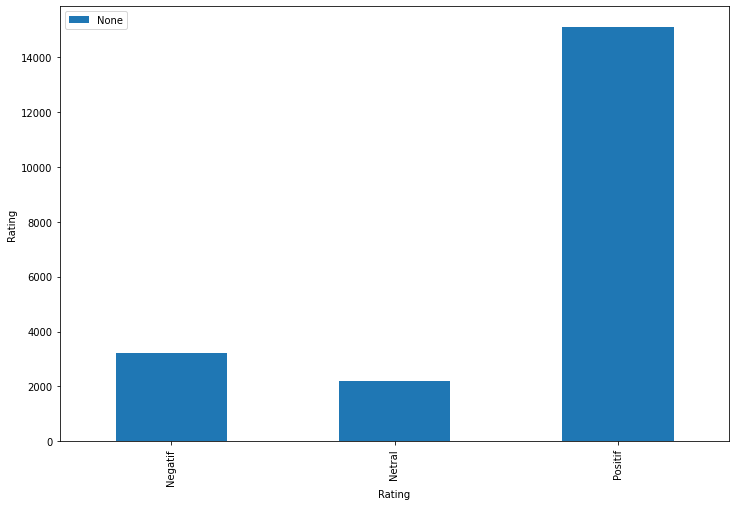

In [ ]:
# visualisasi data kolom Rating
plt.figure(figsize=(12,8))
df.groupby('Rating').size().plot(kind='bar',y='Rating',legend=True)
plt.ylabel('Rating')

In [ ]:

# agar data dapat diproses diubah ke numpy array
Review = df["Review"].values
labels = df[["Rating"]].values
# split dataset validation set menjadi 20% dari total keseluruhan dataset
Review_train, labels_train, Review_test, labels_test = train_test_split(Review,labels, test_size = 0.20, random_state = 42)

In [ ]:
print(Review_train.shape,Review_test.shape)
print(labels_train.shape,labels_test.shape)

(16392,) (16392, 1)
(4099,) (4099, 1)


In [ ]:
# tokenizer
tokenizer = Tokenizer(num_words=15000, oov_token='<OOV>')
tokenizer.fit_on_texts(Review_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict(list(word_index.items())[0:10])

Found 46609 unique tokens.


{'<OOV>': 1,
 'did': 10,
 'good': 7,
 'great': 5,
 'hotel': 2,
 "n't": 6,
 'not': 4,
 'room': 3,
 'staff': 8,
 'stay': 9}

In [ ]:
max_length = 300
pad = 'post'

train_seq = tokenizer.texts_to_sequences(Review_train)
train_padded = pad_sequences(train_seq, maxlen=300, padding=pad, truncating=pad)

validation_seq = tokenizer.texts_to_sequences(labels_train)
validation_padded = pad_sequences(validation_seq, maxlen=300, padding=pad, truncating=pad)
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

Shape of data tensor: (16392, 300)
Shape of data tensor: (4099, 300)


In [ ]:
# one hot encoding 
encode = OneHotEncoder()

training_labels = encode.fit_transform(Review_test)
validation_labels = encode.transform(labels_test)

In [ ]:
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

In [ ]:
# callback ReduceLROnPlateau 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [ ]:
# membuat model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=75000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# callback ModelCheckPoint dan early stopping 
check = 'ML-Dicoding-Check'
path = F"/content/drive/MyDrive/SubmissionDicodingPengembanganML/{check}"


checkpoint = tf.keras.callbacks.ModelCheckpoint(path, 
                                                monitor='val_loss', 
                                                verbose=2,
                                                save_best_only=False, 
                                                save_weights_only=False, 
                                                mode='auto', 
                                                save_freq='epoch', 
                                                options=None)

early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=40,
                      verbose=2,
                      mode='auto')

In [ ]:
epochs = 120
batch_size = 32

history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[checkpoint, early,
                    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
                              #  EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1),
                              #  EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)
                              ])

Epoch 1/120
410/410 [==============================] - 81s 192ms/step - loss: 0.7736 - accuracy: 0.7306 - val_loss: 0.7571 - val_accuracy: 0.7399

Epoch 00001: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 2/120
410/410 [==============================] - 78s 190ms/step - loss: 0.7571 - accuracy: 0.7346 - val_loss: 0.7499 - val_accuracy: 0.7405

Epoch 00002: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 3/120
410/410 [==============================] - 78s 191ms/step - loss: 0.7437 - accuracy: 0.7419 - val_loss: 0.7541 - val_accuracy: 0.7389

Epoch 00003: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 4/120
410/410 [==============================] - 78s 190ms/step - loss: 0.7386 - accuracy: 0.7442 - val_loss: 0.7516 - val_accuracy: 0.7380

Epoch 00004: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 5/120
410/410 [==============================] - 78s 190ms/step - loss: 0.7371 - accuracy: 0.7393 - val_loss: 0.6931 - val_accuracy: 0.7399

Epoch 00005: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 6/120
410/410 [==============================] - 79s 193ms/step - loss: 0.6942 - accuracy: 0.7340 - val_loss: 0.6855 - val_accuracy: 0.7399

Epoch 00006: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 7/120
410/410 [==============================] - 80s 196ms/step - loss: 0.6837 - accuracy: 0.7364 - val_loss: 0.6783 - val_accuracy: 0.7380

Epoch 00007: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 8/120
410/410 [==============================] - 79s 192ms/step - loss: 0.6753 - accuracy: 0.7365 - val_loss: 0.6723 - val_accuracy: 0.7383

Epoch 00008: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 9/120
410/410 [==============================] - 78s 191ms/step - loss: 0.6726 - accuracy: 0.7358 - val_loss: 0.6737 - val_accuracy: 0.7383

Epoch 00009: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 10/120
410/410 [==============================] - 78s 191ms/step - loss: 0.6667 - accuracy: 0.7429 - val_loss: 0.7036 - val_accuracy: 0.7396

Epoch 00010: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 11/120
410/410 [==============================] - 78s 190ms/step - loss: 0.6689 - accuracy: 0.7461 - val_loss: 0.7233 - val_accuracy: 0.7368

Epoch 00011: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 12/120
410/410 [==============================] - 80s 194ms/step - loss: 0.6657 - accuracy: 0.7476 - val_loss: 0.7258 - val_accuracy: 0.7353

Epoch 00012: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 13/120
410/410 [==============================] - 78s 191ms/step - loss: 0.6631 - accuracy: 0.7488 - val_loss: 0.7372 - val_accuracy: 0.7362

Epoch 00013: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 14/120
410/410 [==============================] - 79s 194ms/step - loss: 0.6703 - accuracy: 0.7500 - val_loss: 0.8017 - val_accuracy: 0.7344

Epoch 00014: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 15/120
410/410 [==============================] - 78s 191ms/step - loss: 0.6949 - accuracy: 0.7510 - val_loss: 0.8080 - val_accuracy: 0.7338

Epoch 00015: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 16/120
410/410 [==============================] - 78s 190ms/step - loss: 0.6910 - accuracy: 0.7516 - val_loss: 0.8209 - val_accuracy: 0.7328

Epoch 00016: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 17/120
410/410 [==============================] - 79s 192ms/step - loss: 0.6878 - accuracy: 0.7522 - val_loss: 0.8223 - val_accuracy: 0.7332

Epoch 00017: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 18/120
410/410 [==============================] - 80s 194ms/step - loss: 0.6859 - accuracy: 0.7523 - val_loss: 0.7996 - val_accuracy: 0.7356

Epoch 00018: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 19/120
410/410 [==============================] - 79s 192ms/step - loss: 0.6814 - accuracy: 0.7533 - val_loss: 0.8044 - val_accuracy: 0.7405

Epoch 00019: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 20/120
410/410 [==============================] - 80s 194ms/step - loss: 0.6446 - accuracy: 0.7624 - val_loss: 0.7430 - val_accuracy: 0.7255

Epoch 00020: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 21/120
410/410 [==============================] - 79s 193ms/step - loss: 0.5947 - accuracy: 0.7762 - val_loss: 0.6815 - val_accuracy: 0.7533

Epoch 00021: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 22/120
410/410 [==============================] - 79s 192ms/step - loss: 0.5542 - accuracy: 0.7995 - val_loss: 0.6774 - val_accuracy: 0.7880

Epoch 00022: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 23/120
410/410 [==============================] - 79s 192ms/step - loss: 0.5310 - accuracy: 0.8066 - val_loss: 0.6254 - val_accuracy: 0.7914

Epoch 00023: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 24/120
410/410 [==============================] - 80s 195ms/step - loss: 0.5081 - accuracy: 0.8198 - val_loss: 0.6192 - val_accuracy: 0.7951

Epoch 00024: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 25/120
410/410 [==============================] - 80s 194ms/step - loss: 0.4986 - accuracy: 0.8280 - val_loss: 0.5988 - val_accuracy: 0.8015

Epoch 00025: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 26/120
410/410 [==============================] - 78s 190ms/step - loss: 0.4841 - accuracy: 0.8316 - val_loss: 0.5968 - val_accuracy: 0.8021

Epoch 00026: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 27/120
410/410 [==============================] - 78s 191ms/step - loss: 0.4735 - accuracy: 0.8369 - val_loss: 0.5776 - val_accuracy: 0.8094

Epoch 00027: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 28/120
410/410 [==============================] - 78s 191ms/step - loss: 0.4620 - accuracy: 0.8418 - val_loss: 0.5673 - val_accuracy: 0.8109

Epoch 00028: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 29/120
410/410 [==============================] - 79s 193ms/step - loss: 0.4556 - accuracy: 0.8450 - val_loss: 0.5648 - val_accuracy: 0.8152

Epoch 00029: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 30/120
410/410 [==============================] - 79s 193ms/step - loss: 0.4443 - accuracy: 0.8474 - val_loss: 0.5534 - val_accuracy: 0.8094

Epoch 00030: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 31/120
410/410 [==============================] - 81s 197ms/step - loss: 0.4315 - accuracy: 0.8501 - val_loss: 0.5652 - val_accuracy: 0.8185

Epoch 00031: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 32/120
410/410 [==============================] - 80s 194ms/step - loss: 0.4226 - accuracy: 0.8528 - val_loss: 0.5417 - val_accuracy: 0.8204

Epoch 00032: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 33/120
410/410 [==============================] - 79s 194ms/step - loss: 0.4105 - accuracy: 0.8552 - val_loss: 0.5364 - val_accuracy: 0.8249

Epoch 00033: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 34/120
410/410 [==============================] - 79s 193ms/step - loss: 0.3998 - accuracy: 0.8590 - val_loss: 0.5245 - val_accuracy: 0.8231

Epoch 00034: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 35/120
410/410 [==============================] - 79s 193ms/step - loss: 0.3885 - accuracy: 0.8614 - val_loss: 0.5285 - val_accuracy: 0.8219

Epoch 00035: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 36/120
410/410 [==============================] - 80s 194ms/step - loss: 0.3810 - accuracy: 0.8640 - val_loss: 0.5170 - val_accuracy: 0.8262

Epoch 00036: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 37/120
410/410 [==============================] - 80s 194ms/step - loss: 0.3711 - accuracy: 0.8656 - val_loss: 0.5134 - val_accuracy: 0.8295

Epoch 00037: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 38/120
410/410 [==============================] - 80s 196ms/step - loss: 0.3651 - accuracy: 0.8694 - val_loss: 0.5091 - val_accuracy: 0.8314

Epoch 00038: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 39/120
410/410 [==============================] - 79s 193ms/step - loss: 0.3536 - accuracy: 0.8720 - val_loss: 0.5132 - val_accuracy: 0.8310

Epoch 00039: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 40/120
410/410 [==============================] - 79s 193ms/step - loss: 0.3458 - accuracy: 0.8771 - val_loss: 0.5283 - val_accuracy: 0.8344

Epoch 00040: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 41/120
410/410 [==============================] - 80s 195ms/step - loss: 0.3380 - accuracy: 0.8796 - val_loss: 0.4972 - val_accuracy: 0.8338

Epoch 00041: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 42/120
410/410 [==============================] - 80s 194ms/step - loss: 0.3311 - accuracy: 0.8833 - val_loss: 0.5011 - val_accuracy: 0.8347

Epoch 00042: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 43/120
410/410 [==============================] - 80s 196ms/step - loss: 0.3224 - accuracy: 0.8868 - val_loss: 0.5042 - val_accuracy: 0.8347

Epoch 00043: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 44/120
410/410 [==============================] - 79s 192ms/step - loss: 0.3173 - accuracy: 0.8909 - val_loss: 0.5173 - val_accuracy: 0.8314

Epoch 00044: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 45/120
410/410 [==============================] - 80s 194ms/step - loss: 0.3096 - accuracy: 0.8935 - val_loss: 0.5060 - val_accuracy: 0.8381

Epoch 00045: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 46/120
410/410 [==============================] - 80s 194ms/step - loss: 0.3033 - accuracy: 0.8977 - val_loss: 0.4984 - val_accuracy: 0.8362

Epoch 00046: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 47/120
410/410 [==============================] - 79s 194ms/step - loss: 0.2993 - accuracy: 0.8999 - val_loss: 0.5060 - val_accuracy: 0.8368

Epoch 00047: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 48/120
410/410 [==============================] - 79s 194ms/step - loss: 0.2924 - accuracy: 0.9025 - val_loss: 0.5142 - val_accuracy: 0.8387

Epoch 00048: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 49/120
410/410 [==============================] - 80s 194ms/step - loss: 0.2850 - accuracy: 0.9054 - val_loss: 0.5070 - val_accuracy: 0.8387

Epoch 00049: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 50/120
410/410 [==============================] - 81s 197ms/step - loss: 0.2791 - accuracy: 0.9072 - val_loss: 0.5149 - val_accuracy: 0.8371

Epoch 00050: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 51/120
410/410 [==============================] - 79s 193ms/step - loss: 0.2740 - accuracy: 0.9120 - val_loss: 0.5190 - val_accuracy: 0.8375

Epoch 00051: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 52/120
410/410 [==============================] - 80s 194ms/step - loss: 0.2675 - accuracy: 0.9150 - val_loss: 0.5344 - val_accuracy: 0.8390

Epoch 00052: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 53/120
410/410 [==============================] - 80s 195ms/step - loss: 0.2618 - accuracy: 0.9161 - val_loss: 0.5392 - val_accuracy: 0.8353

Epoch 00053: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 54/120
410/410 [==============================] - 80s 194ms/step - loss: 0.2577 - accuracy: 0.9189 - val_loss: 0.5320 - val_accuracy: 0.8381

Epoch 00054: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 55/120
410/410 [==============================] - 80s 195ms/step - loss: 0.2524 - accuracy: 0.9222 - val_loss: 0.5263 - val_accuracy: 0.8381

Epoch 00055: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 56/120
410/410 [==============================] - 81s 197ms/step - loss: 0.2452 - accuracy: 0.9248 - val_loss: 0.5413 - val_accuracy: 0.8368

Epoch 00056: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 57/120
410/410 [==============================] - 80s 196ms/step - loss: 0.2410 - accuracy: 0.9264 - val_loss: 0.5527 - val_accuracy: 0.8338

Epoch 00057: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 58/120
410/410 [==============================] - 80s 195ms/step - loss: 0.2361 - accuracy: 0.9277 - val_loss: 0.5532 - val_accuracy: 0.8359

Epoch 00058: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 59/120
410/410 [==============================] - 79s 193ms/step - loss: 0.2332 - accuracy: 0.9288 - val_loss: 0.5642 - val_accuracy: 0.8344

Epoch 00059: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 60/120
410/410 [==============================] - 78s 191ms/step - loss: 0.2290 - accuracy: 0.9318 - val_loss: 0.5483 - val_accuracy: 0.8384

Epoch 00060: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 61/120
410/410 [==============================] - 79s 193ms/step - loss: 0.2232 - accuracy: 0.9337 - val_loss: 0.5965 - val_accuracy: 0.8268

Epoch 00061: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 62/120
410/410 [==============================] - 81s 198ms/step - loss: 0.2224 - accuracy: 0.9347 - val_loss: 0.5477 - val_accuracy: 0.8356

Epoch 00062: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 63/120
410/410 [==============================] - 80s 194ms/step - loss: 0.2222 - accuracy: 0.9342 - val_loss: 0.5865 - val_accuracy: 0.8326

Epoch 00063: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 64/120
410/410 [==============================] - 81s 196ms/step - loss: 0.2125 - accuracy: 0.9376 - val_loss: 0.5766 - val_accuracy: 0.8365

Epoch 00064: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 65/120
410/410 [==============================] - 80s 195ms/step - loss: 0.2137 - accuracy: 0.9378 - val_loss: 0.5872 - val_accuracy: 0.8317

Epoch 00065: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 66/120
410/410 [==============================] - 80s 194ms/step - loss: 0.2086 - accuracy: 0.9398 - val_loss: 0.5783 - val_accuracy: 0.8353

Epoch 00066: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 67/120
410/410 [==============================] - 79s 193ms/step - loss: 0.2081 - accuracy: 0.9395 - val_loss: 0.5799 - val_accuracy: 0.8323

Epoch 00067: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 68/120
410/410 [==============================] - 80s 195ms/step - loss: 0.2038 - accuracy: 0.9409 - val_loss: 0.5979 - val_accuracy: 0.8323

Epoch 00068: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 69/120
410/410 [==============================] - 81s 198ms/step - loss: 0.2214 - accuracy: 0.9346 - val_loss: 0.5927 - val_accuracy: 0.8323

Epoch 00069: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 70/120
410/410 [==============================] - 81s 198ms/step - loss: 0.2352 - accuracy: 0.9249 - val_loss: 0.5702 - val_accuracy: 0.8323

Epoch 00070: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 71/120
410/410 [==============================] - 79s 193ms/step - loss: 0.2002 - accuracy: 0.9427 - val_loss: 0.6039 - val_accuracy: 0.8301

Epoch 00071: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 72/120
410/410 [==============================] - 80s 195ms/step - loss: 0.2185 - accuracy: 0.9318 - val_loss: 0.6003 - val_accuracy: 0.8332

Epoch 00072: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 73/120
410/410 [==============================] - 80s 194ms/step - loss: 0.1976 - accuracy: 0.9436 - val_loss: 0.5916 - val_accuracy: 0.8314

Epoch 00073: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 74/120
410/410 [==============================] - 80s 196ms/step - loss: 0.1902 - accuracy: 0.9461 - val_loss: 0.6077 - val_accuracy: 0.8326

Epoch 00074: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 75/120
410/410 [==============================] - 80s 195ms/step - loss: 0.1893 - accuracy: 0.9463 - val_loss: 0.6047 - val_accuracy: 0.8329

Epoch 00075: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 76/120
410/410 [==============================] - 81s 197ms/step - loss: 0.1847 - accuracy: 0.9480 - val_loss: 0.6211 - val_accuracy: 0.8335

Epoch 00076: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 77/120
410/410 [==============================] - 80s 195ms/step - loss: 0.1848 - accuracy: 0.9475 - val_loss: 0.6206 - val_accuracy: 0.8314

Epoch 00077: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 78/120
410/410 [==============================] - 80s 194ms/step - loss: 0.2010 - accuracy: 0.9402 - val_loss: 0.6034 - val_accuracy: 0.8304

Epoch 00078: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 79/120
410/410 [==============================] - 81s 198ms/step - loss: 0.1824 - accuracy: 0.9478 - val_loss: 0.6279 - val_accuracy: 0.8335

Epoch 00079: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 80/120
410/410 [==============================] - 80s 196ms/step - loss: 0.1915 - accuracy: 0.9432 - val_loss: 0.6365 - val_accuracy: 0.8304

Epoch 00080: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 81/120
410/410 [==============================] - 81s 197ms/step - loss: 0.1753 - accuracy: 0.9493 - val_loss: 0.6275 - val_accuracy: 0.8310

Epoch 00081: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 82/120
410/410 [==============================] - 80s 195ms/step - loss: 0.1727 - accuracy: 0.9514 - val_loss: 0.6510 - val_accuracy: 0.8283

Epoch 00082: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 83/120
410/410 [==============================] - 80s 196ms/step - loss: 0.1750 - accuracy: 0.9495 - val_loss: 0.6462 - val_accuracy: 0.8262

Epoch 00083: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 84/120
410/410 [==============================] - 80s 194ms/step - loss: 0.1793 - accuracy: 0.9468 - val_loss: 0.6433 - val_accuracy: 0.8289

Epoch 00084: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 85/120
410/410 [==============================] - 80s 195ms/step - loss: 0.2396 - accuracy: 0.9199 - val_loss: 0.6173 - val_accuracy: 0.8280

Epoch 00085: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 86/120
410/410 [==============================] - 79s 193ms/step - loss: 0.1844 - accuracy: 0.9433 - val_loss: 0.6196 - val_accuracy: 0.8295

Epoch 00086: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 87/120
410/410 [==============================] - 81s 198ms/step - loss: 0.1691 - accuracy: 0.9514 - val_loss: 0.6953 - val_accuracy: 0.8338

Epoch 00087: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 88/120
410/410 [==============================] - 80s 196ms/step - loss: 0.1848 - accuracy: 0.9450 - val_loss: 0.6540 - val_accuracy: 0.8335

Epoch 00088: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 89/120
410/410 [==============================] - 82s 199ms/step - loss: 0.1644 - accuracy: 0.9534 - val_loss: 0.6593 - val_accuracy: 0.8295

Epoch 00089: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 90/120
410/410 [==============================] - 80s 194ms/step - loss: 0.2392 - accuracy: 0.9231 - val_loss: 0.6253 - val_accuracy: 0.8295

Epoch 00090: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 91/120
410/410 [==============================] - 80s 194ms/step - loss: 0.1728 - accuracy: 0.9492 - val_loss: 0.6371 - val_accuracy: 0.8286

Epoch 00091: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 92/120
410/410 [==============================] - 81s 197ms/step - loss: 0.2180 - accuracy: 0.9258 - val_loss: 0.6203 - val_accuracy: 0.8332

Epoch 00092: saving model to /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/SubmissionDicodingPengembanganML/ML-Dicoding-Check/assets


Epoch 00092: early stopping


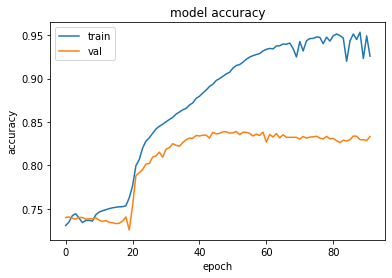

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

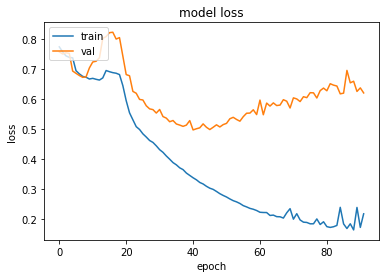

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Evaluasi Model dan Membuat Prediksi
predicted = model.predict(validation_padded)
y_true = np.argmax(validation_labels, axis=1)
y_preds = np.argmax(predicted, axis=1)

accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds, average='micro')
recall = recall_score(y_true, y_preds, average='micro')
f1 = f1_score(y_true, y_preds, average='micro')
metric_dict = {"accuracy": round(accuracy, 2),
               "precision": round(precision, 2),
                "recall": round(recall, 2),
                "f1": round(f1, 2)}
print(f"Acc: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Acc: 82.51%
Precision: 0.83
Recall: 0.83
F1 score: 0.83
